## **EXP1 Predicting Missing Cell-Types from Bulks using the Residual**

*This file creates the EXP1 pseudobulks from the data outlined below, and creates the files needed to get barcode genes from CIBERSORTx*

Code based on:
1. https://github.com/nrosed/sc_bulk_ood/blob/main/sc_preprocessing/2_make_pseudobulks/scanpy_sc_preprocess_pbmc6k.ipynb
2. https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

**Data Details:**

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE176171
Original paper: https://pubmed.ncbi.nlm.nih.gov/35296864/ PMID: 35296864

Source name	omental adipose tissue
Organism	Homo sapiens
Characteristics	tissue: white adipose tissue
Sex: female
age: 29y
bmi: 49.3
surgery: VSG

**Summary:**

For the initial study, we used a single-nucleus RNA-seq dataset with 14 cell-types derived from adipose, and extracted the expression of five immune cell types (macrophage, T cell, B cell, monocyte, dendritic cell) with distinct expression. Pseudobulks were created for deconvolution by generating a random proportion vector, and defining the total number of cells per bulk as 5000. Creating 1000 realistic-proportions pseudobulks in 10 separate files with each file containing 1000 bulks. 

*This file can be run one kernel at a time, or all at once*


In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_snadp_EXP1"
actual_path = os.getcwd()
path = f"{actual_path}/../data/"
aug_data_path = f"{actual_path}/../data/EXP1/"
cibersort_path = f"{aug_data_path}cibersort/"
adata_path = f"{actual_path}/../data/"
random_seed = 88
#if you want pseudobulks to be made, change to True before running:
make_pseudos = False
#to extract barcode genes later
prep_cibersort = False

## **Reading in all the data:**

In [3]:
#metadata containing cell types
cell_meta_name = f"{aug_data_path}GSE176171_cell_metadata.tsv.gz"
cell_meta = pd.read_csv(cell_meta_name, sep='\t')
cell_meta

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (19,20,21,22,23,24,30,32,33,36,37,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,donor_id,species__ontology_id,species__ontology_label,organ__ontology_id,organ__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__ontology_id,cell_type__ontology_label,cell_type__custom,cell_subtype__custom
0,Hs_OAT_01-1_AAACCCAAGCAAGGAA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.320758,5042,3178,0.013315,-0.002799,S,CL:0000077,mesothelial cell,mesothelium,hMes1
1,Hs_OAT_01-1_AAACCCAAGGGTGGGA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.489574,4905,2578,-0.051260,-0.012629,G1,CL:0000235,macrophage,macrophage,hMac3
2,Hs_OAT_01-1_AAACCCAAGTCTGGAG,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.599401,3607,1808,0.046359,-0.009526,S,CL:0000235,macrophage,macrophage,hMac1
3,Hs_OAT_01-1_AAACCCACAGCCCAGT,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.420800,5029,3041,0.018981,0.021519,G2M,CL:0000077,mesothelial cell,mesothelium,hMes3
4,Hs_OAT_01-1_AAACCCACATCTTCGC,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.166098,4776,2539,0.028879,-0.005132,S,CL:0000136,fat cell,adipocyte,hAd2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363865,Mm_POV_04-1_TTTGTTGCACTAGGTT,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.000000,1332,404,-0.006680,0.010435,G2M,CL:0002334,preadipocyte,ASPC,mASPC2
363866,Mm_POV_04-1_TTTGTTGGTATCATGC,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.086059,1466,776,-0.010295,-0.023509,G1,CL:0000136,fat cell,adipocyte,mAd1
363867,Mm_POV_04-1_TTTGTTGGTCCTGGTG,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.070028,1528,991,-0.017319,-0.007133,G1,CL:0000077,mesothelial cell,mesothelium,mMes1
363868,Mm_POV_04-1_TTTGTTGGTGTATTGC,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.138504,1478,511,-0.005107,0.027213,G2M,CL:0000077,mesothelial cell,mesothelium,mMes2


In [4]:
#adata containing count matrix
adata = sc.read_10x_mtx(f"{aug_data_path}/", prefix = 'GSE176171_Hs10X.counts.', var_names='gene_symbols', make_unique=True)
adata

Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].


AnnData object with n_obs × n_vars = 137684 × 29093
    var: 'gene_ids', 'feature_types'

In [5]:
#extracting cell ids for meta
cell_ids = cell_meta[cell_meta["biosample_id"] == "Hs_OAT_01-1"]["cell_type__ontology_label"].values	
cell_ids = vp.capitalize_first_letters(cell_ids)
cell_ids

['Mesothelial cell',
 'Macrophage',
 'Macrophage',
 'Mesothelial cell',
 'Fat cell',
 'Macrophage',
 'Fat cell',
 'T cell',
 'Mesothelial cell',
 'Macrophage',
 'Fat cell',
 'Mesothelial cell',
 'Preadipocyte',
 'Preadipocyte',
 'T cell',
 'Smooth muscle cell',
 'Mesothelial cell',
 'Macrophage',
 'Mesothelial cell',
 'Endothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'Endothelial cell',
 'Endothelial cell of lymphatic vessel',
 'Macrophage',
 'Mesothelial cell',
 'Mesothelial cell',
 'Dendritic cell',
 'Mesothelial cell',
 'T cell',
 'Endothelial cell of lymphatic vessel',
 'Smooth muscle cell',
 'Macrophage',
 'Preadipocyte',
 'Preadipocyte',
 'Preadipocyte',
 'T cell',
 'T cell',
 'Endothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'T cell',
 'Preadipocyte',
 'Mesothelial cell',
 'Preadipocyte',
 'Endothelial cell',
 'Mesothelial cell',
 'Mesothelial cell',
 'Preadipocyte',
 'Mesothelial cell',
 'P

In [6]:
#getting common cells between meta and count matrix
common_cells = np.intersect1d([adata.obs.index], [cell_meta["cell_id"].values])
common_cells= list(common_cells)
#num of cells total
len(common_cells)

137684

In [7]:
#make index the same to assign cell types
cell_meta.index = cell_meta["cell_id"]
cell_meta = cell_meta.loc[common_cells]
adata.var["gene_ids"] = adata.var.index
adata

AnnData object with n_obs × n_vars = 137684 × 29093
    var: 'gene_ids', 'feature_types'

In [8]:
#naming sn_adata (single nucleus)
sn_adata = adata.copy()

## **QC of count matrix:**

Based on:
Scanpy https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

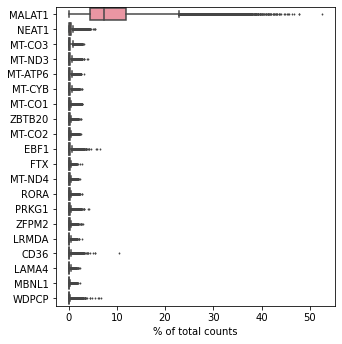

In [9]:
sc.pl.highest_expr_genes(sn_adata, n_top=20, )

In [10]:
#filtering genes and cells 
sc.pp.filter_cells(sn_adata, min_genes=300)
sc.pp.filter_genes(sn_adata, min_cells=7)

In [11]:
sn_adata

AnnData object with n_obs × n_vars = 137660 × 28242
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


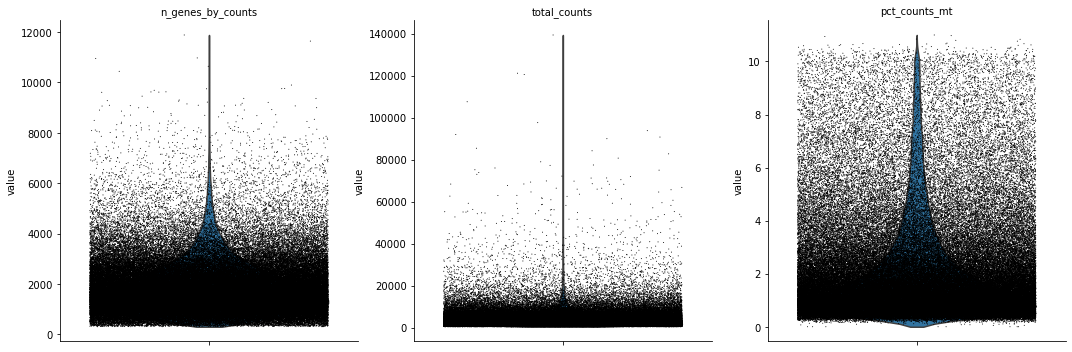

In [12]:
# remove genes with high mitochondrial content
sn_adata.var['mt'] = sn_adata.var_names.str.startswith('MT')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sn_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(sn_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

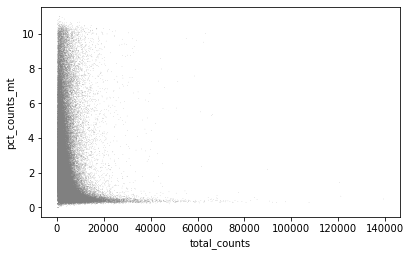

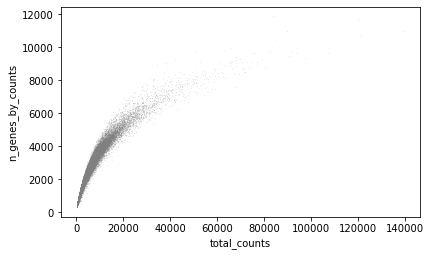

In [13]:
sc.pl.scatter(sn_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sn_adata, x='total_counts', y='n_genes_by_counts')

In [14]:
sn_adata = sn_adata[sn_adata.obs.n_genes_by_counts < 6000, :]
sn_adata = sn_adata[sn_adata.obs.pct_counts_mt < 4, :]

In [15]:
#making copy to keep unnormalized for export
sn_adata_copy = sn_adata.copy()
sn_adata_copy

AnnData object with n_obs × n_vars = 116066 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [16]:
# normalize to 10K counts per cell
sc.pp.normalize_total(sn_adata, target_sum=1e4)
#logging local adata
sc.pp.log1p(sn_adata)

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


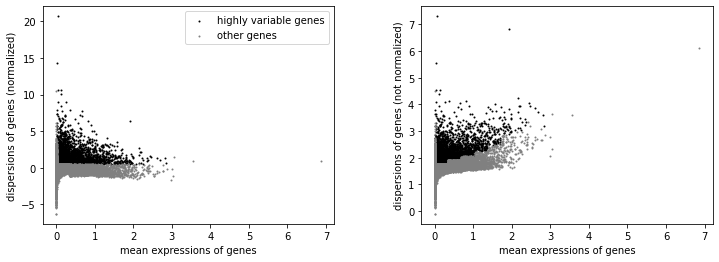

In [17]:
#saving highly variable genes
highly_var_genes = sc.pp.highly_variable_genes(sn_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(sn_adata)

**Assigning cell types:**

In [18]:
# Merge the two DataFrames based on the indexes from before
merged_df = pd.merge(sn_adata.obs, cell_meta, left_index=True, right_index=True)
merged_df

,n_genes_x,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__ontology_id,cell_type__ontology_label,cell_type__custom,cell_subtype__custom
Hs_OAT_12-1_AAACCCAAGCTCGTGC,1023,1023,1309.0,19.0,1.451490,Hs_OAT_12-1_AAACCCAAGCTCGTGC,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,1.069519,1681,1023,-0.026009,-0.015240,G1,CL:0000077,mesothelial cell,mesothelium,hMes1
Hs_OAT_12-1_AAACCCAAGTTCGCAT,1666,1666,3549.0,42.0,1.183432,Hs_OAT_12-1_AAACCCAAGTTCGCAT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.309946,2692,1666,-0.011481,-0.013545,G1,CL:0000136,fat cell,adipocyte,hAd2
Hs_OAT_12-1_AAACCCACAAGCAGGT,3639,3639,10669.0,400.0,3.749180,Hs_OAT_12-1_AAACCCACAAGCAGGT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.215578,2280,1270,-0.000967,0.002635,G2M,CL:0000136,fat cell,adipocyte,hAd2
Hs_OAT_12-1_AAACCCACAAGGGCAT,1805,1805,2822.0,37.0,1.311127,Hs_OAT_12-1_AAACCCACAAGGGCAT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.602410,2670,1805,0.022549,-0.014975,S,CL:0000077,mesothelial cell,mesothelium,hMes2
Hs_OAT_12-1_AAACCCACACCCTGAG,2326,2326,4766.0,31.0,0.650441,Hs_OAT_12-1_AAACCCACACCCTGAG,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.314729,2989,2060,-0.020035,-0.006758,G1,CL:0000136,fat cell,adipocyte,hAd2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hs_SAT_11-1_TTTGGAGGTTGCTCAA,1769,1769,2978.0,74.0,2.484889,Hs_SAT_11-1_TTTGGAGGTTGCTCAA,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,3.626595,2951,1769,-0.047193,-0.023121,G1,CL:0000914,immature NK T cell,nk_cell,hNK
Hs_SAT_11-1_TTTGGAGTCTCCGATC,1813,1813,3184.0,58.0,1.821608,Hs_SAT_11-1_TTTGGAGTCTCCGATC,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.251256,3066,1811,0.008630,0.010638,G2M,CL:0002334,preadipocyte,ASPC,hASPC5
Hs_SAT_11-1_TTTGGTTAGTGATGGC,4520,4520,17086.0,50.0,0.292637,Hs_SAT_11-1_TTTGGTTAGTGATGGC,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.163877,2913,1778,-0.006596,-0.022388,G1,CL:0000136,fat cell,adipocyte,hAd4
Hs_SAT_11-1_TTTGGTTTCATGCCAA,1171,1171,1758.0,39.0,2.218430,Hs_SAT_11-1_TTTGGTTTCATGCCAA,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.000000,2255,1171,0.001052,-0.011141,S,CL:0000136,fat cell,adipocyte,hAd2


In [19]:
# Extract the cell type labels from the merged DataFrame
cell_type_labels = vp.capitalize_first_letters(merged_df["cell_type__ontology_label"])

# Assign the cell type labels to the adata.obs DataFrame
sn_adata.obs["cell_types"] = cell_type_labels
sn_adata_copy.obs["cell_types"] = cell_type_labels
sn_adata_copy.var["highly_var_genes"] = sn_adata.var["highly_variable"]

In [20]:
####QC### celltype assignments:  
sn_adata['Hs_OAT_12-1_AAACCCAAGCTCGTGC'].obs["cell_types"] == cell_meta["cell_type__ontology_label"]['Hs_OAT_12-1_AAACCCAAGCTCGTGC']

Hs_OAT_12-1_AAACCCAAGCTCGTGC    False
Name: cell_types, dtype: bool

In [21]:
#saving for later adata as anndata without normalization
adata_path = os.path.join(aug_data_path, f"{res_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata_copy.write_h5ad(adata_path)

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical


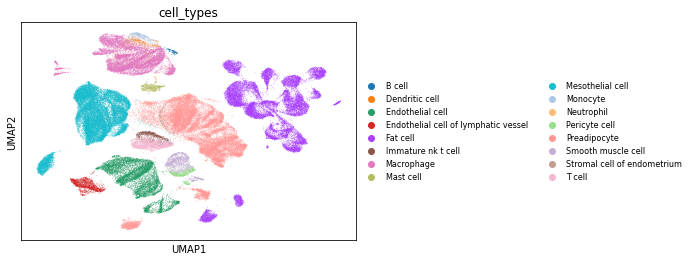

In [22]:
# calculate neighborhood graph
sc.pp.neighbors(sn_adata)

# make umap
sc.tl.umap(sn_adata)

# plot some markers of the RAW data
sc.pl.umap(sn_adata, color='cell_types', legend_fontsize=8)

In [23]:
Counter(sn_adata.obs["cell_types"]) #all cell types counted

Counter({'Mesothelial cell': 26276,
         'Fat cell': 24825,
         'Macrophage': 13625,
         'Preadipocyte': 26941,
         'Endothelial cell': 11480,
         'Endothelial cell of lymphatic vessel': 2339,
         'Pericyte cell': 1165,
         'T cell': 3022,
         'Smooth muscle cell': 2457,
         'B cell': 231,
         'Dendritic cell': 679,
         'Mast cell': 883,
         'Monocyte': 709,
         'Stromal cell of endometrium': 284,
         'Immature nk t cell': 1073,
         'Neutrophil': 77})

In [24]:
adata_path = os.path.join(aug_data_path, f"{res_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata_copy = sc.read_h5ad(adata_path)
Counter(sn_adata_copy.obs.cell_types)

Counter({'Mesothelial cell': 26276,
         'Fat cell': 24825,
         'Macrophage': 13625,
         'Preadipocyte': 26941,
         'Endothelial cell': 11480,
         'Endothelial cell of lymphatic vessel': 2339,
         'Pericyte cell': 1165,
         'T cell': 3022,
         'Smooth muscle cell': 2457,
         'B cell': 231,
         'Dendritic cell': 679,
         'Mast cell': 883,
         'Monocyte': 709,
         'Stromal cell of endometrium': 284,
         'Immature nk t cell': 1073,
         'Neutrophil': 77})

In [25]:
exclude = ['preadipocyte',
    'mesothelial cell',
    'pericyte cell',
    'fat cell',
    'endothelial cell',
    'endothelial cell of lymphatic vessel',
    'smooth muscle cell',
    'mast cell',
    'immature NK T cell',
    'stromal cell of endometrium',
    'neutrophil']
exclude = vp.capitalize_first_letters(exclude)
sn_adata_cut = sn_adata_copy[~sn_adata_copy.obs["cell_types"].isin(exclude), :]
#Tilde is “not”, so this reads like “var names that are not in exclude”
Counter(sn_adata_cut.obs["cell_types"])

Counter({'Macrophage': 13625,
         'T cell': 3022,
         'B cell': 231,
         'Dendritic cell': 679,
         'Monocyte': 709})

In [26]:
# no specific cell noise 
sn_adata_cut.obs["scpred_CellType"] = sn_adata_cut.obs["cell_types"]
len_vector = sn_adata_cut.obs["cell_types"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, sn_adata_cut.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = sn_adata_cut.obs.cell_types.unique()
#custom proportion of equal prop / cell
num_cells = len_vector
custom_prop = np.array([(1/num_cells)]*num_cells)
custom_prop  =  pd.DataFrame(custom_prop).T
custom_prop.columns = cell_order
custom_prop

Trying to set attribute `.obs` of view, copying.


,Macrophage,T cell,B cell,Dendritic cell,Monocyte
0,0.2,0.2,0.2,0.2,0.2


Visualize cell types, first for all cell types, and then for the chosen 5:

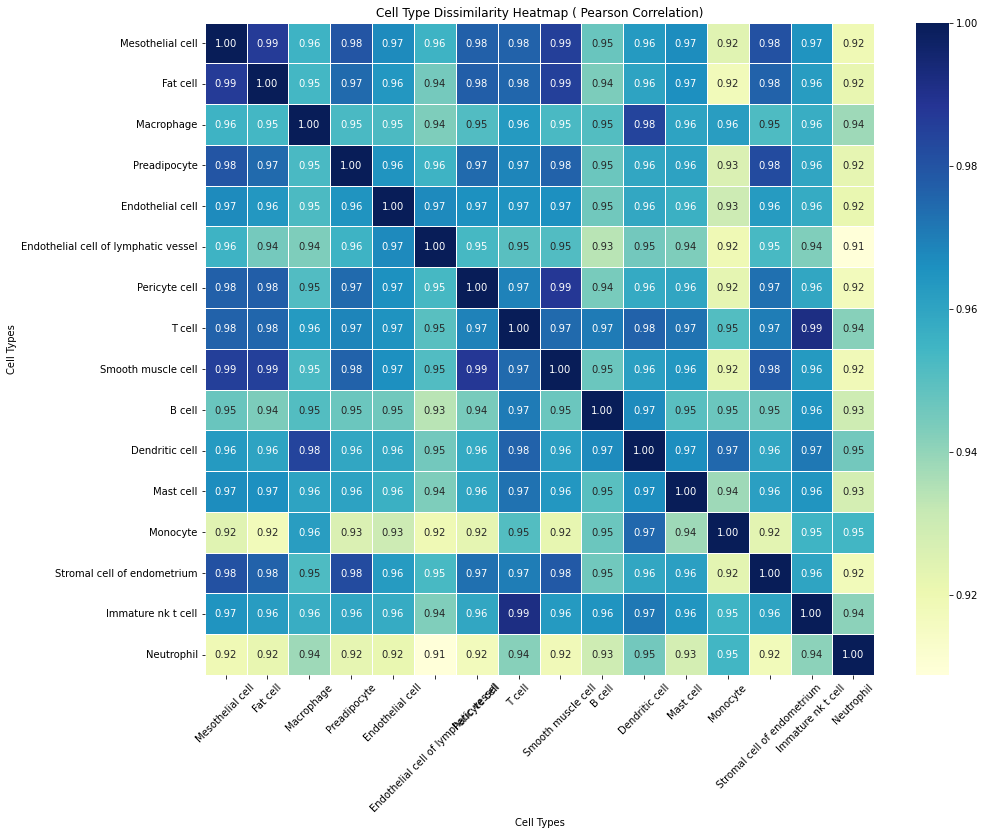

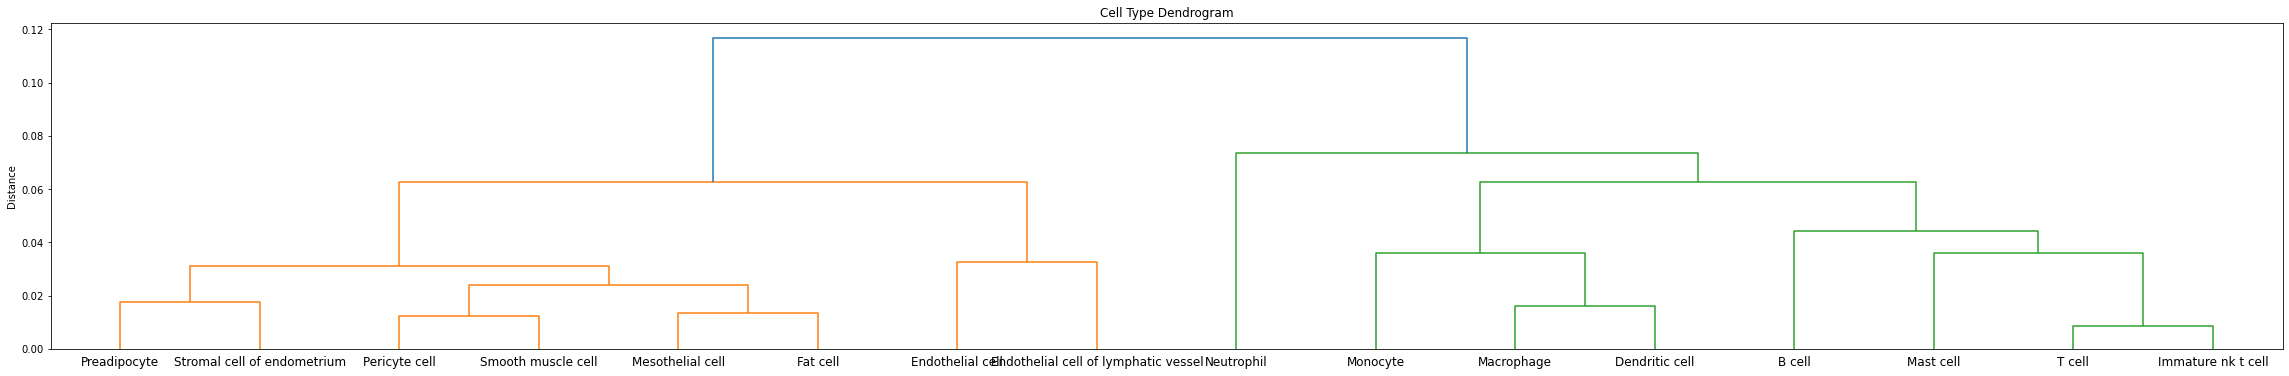

In [27]:
# Define the number of samples for resampling
num_samples = 5000

# Making cell type reference without scaling
cell_types = sn_adata_copy.obs["cell_types"].unique()
gene_ids = sn_adata_copy.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = sn_adata_copy[sn_adata_copy.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(40, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()

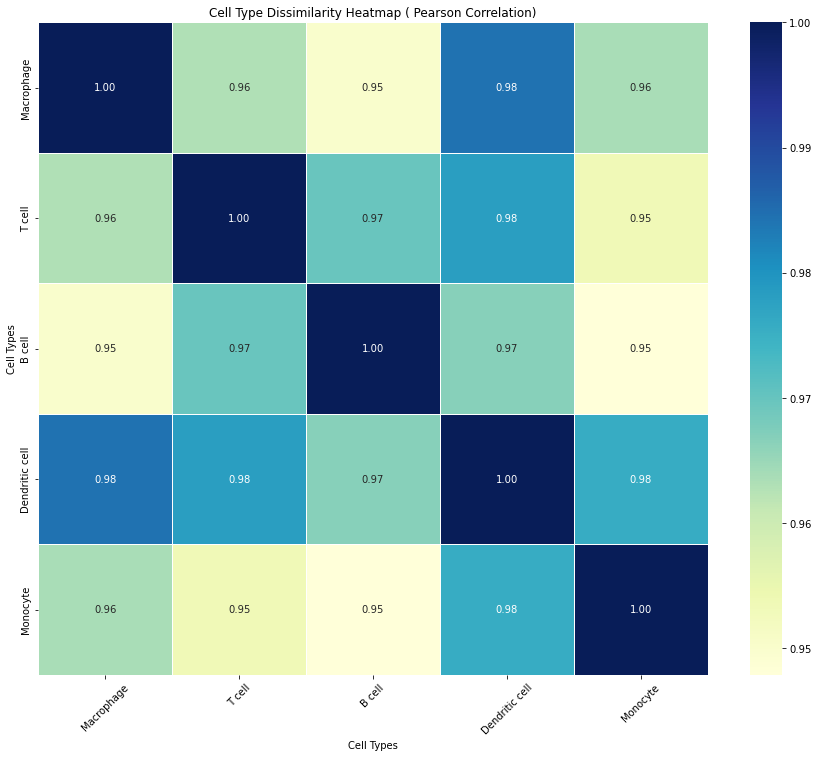

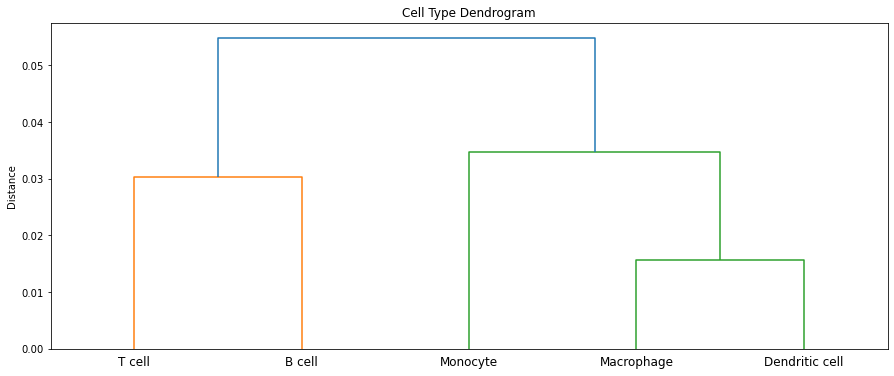

In [28]:
# Making cell type reference without scaling
cell_types = sn_adata_cut.obs["cell_types"].unique()
gene_ids = sn_adata_cut.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = sn_adata_cut[sn_adata_cut.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(15, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()


In [ ]:
#Final number of cells and genes after QC
sn_adata.X.shape

(116066, 28242)

## **Pseudobulk-Creating Loops**
2. 5 Cell Types only, No noise added

Run all or one at a time as needed.

5 Cell Types, NO Noise:

In [ ]:
sampling_adata = sn_adata_cut
num_cells = 5000
num_random = 200
sample_noise = None
noise_type = "No noise"
if make_pseudos:  
        for idx in range(0,10):
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the reall cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type=noise_type)

                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise, noise_type=noise_type)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise, noise_type= noise_type)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_5CTnonoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_5CTnonoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

In [ ]:
# write out the gene ids in intersection file
genes_all = adata.var["gene_ids"]
gene_out_file = os.path.join(aug_data_path, f"{res_name}_intersection_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( genes_all, open(gene_out_path, "wb" ) )

In [ ]:
sn_adata_copy = sn_adata_cut

**QC Pseudobulks Made:**

In [ ]:
#defining number of bulks depending on num of cell types
num_cell_type_specific = 50 * int(sn_adata_copy.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

850

In [ ]:
#reading files
X_full, Y_full, gene_df, meta_df = sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path,
                    noise_type= "5CTnonoise_", file_name = res_name, num_bulks_training = num_bulks, 
                    num_files=1, random_selection=False)

0


(850, 2)
(850, 2)


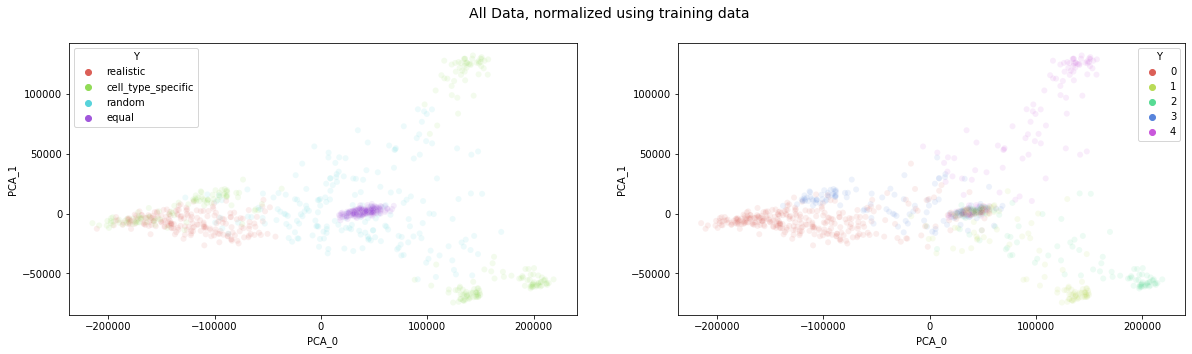

In [ ]:
#visualuzing PCA
plot_df = vp.get_pca_for_plotting(X_full)

fig, axs = plt.subplots(1, 2, figsize=(20,5))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[1], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 850 samples in 0.008s...
[t-SNE] Computed neighbors for 850 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 850 / 850
[t-SNE] Mean sigma: 7438.368554
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.266338
[t-SNE] KL divergence after 500 iterations: 0.418142
(850, 2)
(850, 2)


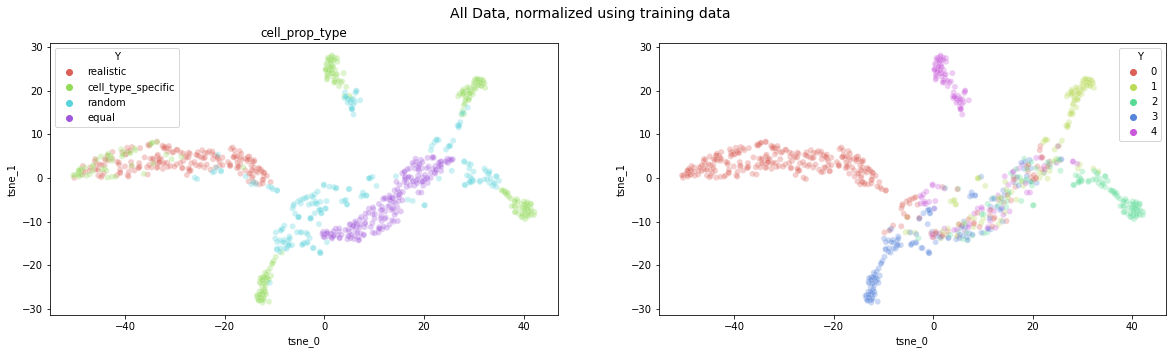

In [ ]:
#visualuzing TSNE
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(1, 2, figsize=(20,5))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[0], title=f"cell_prop_type")
vp.plot_tsne(plot_df, Y_temp, axs[1], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

## **CIBERSORTx Preparation:**
This is run to get the cell specific barcode genes from CIBERSORTx.

In [ ]:
if prep_cibersort:
    #and as anndata object
    adata_path_ = os.path.join(adata_path)
    print(adata_path_)
    adata_path_ = Path(adata_path_)
    sn_adata_copy = sc.read_h5ad(adata_path_)
    print(Counter(sn_adata_copy.obs.cell_types))

If you need to delete cells in large cell types if running CIBERSORTx online. If running CIBERSORTx online, file size limit is reached with too many cells.

Keeping our curated set of cells only

In [ ]:
#Keeping only our curated set of cells
if prep_cibersort:
    # Assuming 'cell_types' is a categorical variable in the obs axis
    # and you want to keep only specific cell types
    desired_cell_types = ['Macrophage', 'T cell', 'Monocyte', 'Dendritic cell', 'B cell']

    # Filter the AnnData object, making sure we only have our cell types of interest.
    sn_adata_copy = sn_adata_copy[sn_adata_copy.obs['cell_types'].isin(desired_cell_types)]
    # Display the filtered AnnData object
    print(sn_adata_copy)

In [ ]:
if prep_cibersort:
    dense_matrix = sn_adata_copy.X.todense()

    sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
    sc_profile_path = Path(sc_profile_file)

    dense_df = pd.DataFrame(dense_matrix, columns = sn_adata_copy.var_names)
    dense_df.insert(loc=0, column='cell_types', value=sn_adata_copy.obs["cell_types"].to_list())
    #save file
    pickle.dump( dense_df, open( sc_profile_path, "wb" ) )
    #qc
    sig_df_sn = dense_df
    sig_df_sn.shape

    X_full.columns = sn_adata_copy.var_names

In [ ]:
if prep_cibersort:
    #cut to only the random samples
    X_full.index = meta_df.index
    #now we import all bulks and transpose
    X_train = X_full.transpose()
    X_train.columns = range(X_train.shape[1])

In [ ]:
if prep_cibersort:
    #details
    exp_id = f"{res_name}"
    patient_idx =f"0"
    #and create files for CIBERSORTX
    _, sig_sn = sn_sc_preprocess.write_cs_bp_files(cibersort_path, exp_id, sig_df_sn, X_train, patient_idx)

Final files for CIBERSORTx QC:

In [ ]:
if prep_cibersort:
    print(sig_sn)